In [1]:
%load_ext autoreload
%autoreload 2

/var/folders/t9/xqv32vzn2pb091tj9_rz1_zh0000gn/T/ipykernel_86094/3794814487.py:40: DeprecationWarning: The class ``qiskit.providers.models.backendconfiguration.QasmBackendConfiguration`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The models in ``qiskit.providers.models`` are part of the deprecated `BackendV1` workflow and no longer necessary for `BackendV2`. If a user workflow requires these representations it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  fake_backend = AerSimulator.from_backend(backend)


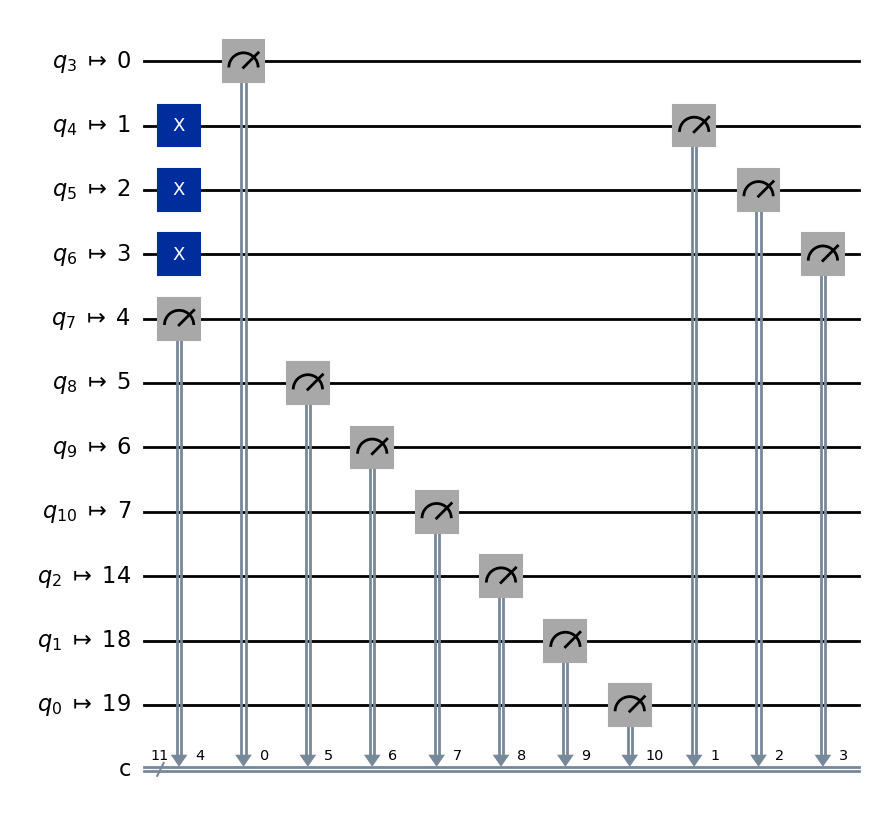

In [2]:
from z2chain.operators import local_pauli_z, local_pauli_x, postselection_operators
from z2chain.circs import erradj_particle_pair_quench_simulation_circuits
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance2
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB
from functools import partial
import numpy as np

L_arr = [6]
J = 1
h = 0.05
lamb = 0.7
g = None

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [10000]
optimization_levels = [0]
zne_extrapolator_levels = [("linear", [1, 1.2, 1.5])] #[None, ("linear", [1, 1.2, 1.5]), ("linear", [1, 2, 3]), ("linear", [1, 3, 5])]
measure_mitigations = [True]
dd_sequences = ["XY4"]
twirlings = [True]

execution_database = "z2_postselection_tests.json"
job_db = ExecDB(execution_database)

service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token, instance=group_instance2)
channel = "ibm_quantum"
backend = service.backend("ibm_kyiv")

from qiskit_aer import AerSimulator
fake_backend = AerSimulator.from_backend(backend)

eplg_absolute = 1.86e-2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] # observable_generating_funcs[L][i]
postselection_operators_funcs = [] # postselection_operators_funcs[L]

sampler_options = {
    "default_shots": 10000,
    # "execution": {
    #     "init_qubits": True,
    #     "meas_type": "classified"
    # },
    # "dynamical_decoupling": {
    #     "enable": False,
    #     "sequence_type": "XY4"
    # },
    # "twirling": {
    #     "enable_gates": False,
    #     "enable_measure": False,
    #     "num_randomizations": "auto",
    #     "shots_per_randomization": "auto"
    # }
}

from qiskit.quantum_info import Pauli
from utils.hexec import get_backend_best_qubit_chain

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    layout = get_backend_best_qubit_chain(backend, 2*L-1)
    physical_circuits = erradj_particle_pair_quench_simulation_circuits(L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level=2, eplg_absolute=eplg_absolute, g=g, layout=layout, x_basis=x_basis)
    observable_generating_funcs.append([partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)])
    postselection_operators_funcs.append(lambda nqubits: postselection_operators((nqubits + 1)//2, x_basis))
    # physical_circuits[0].measure(np.arange(2*L-1), np.arange(2*L-1))
    circuits.append(physical_circuits)

circuits[0][0].draw(output="mpl", idle_wires=False)

In [3]:
circuits[0][1].layout.final_index_layout()

[19, 18, 14, 0, 1, 2, 3, 4, 5, 6, 7]

In [4]:
from utils.postselection import get_layout_state

sstring_reordering = get_layout_state("00000000001", circuits[0][1].layout.final_index_layout())
sstring_reordering

'00000001000'

### Plots

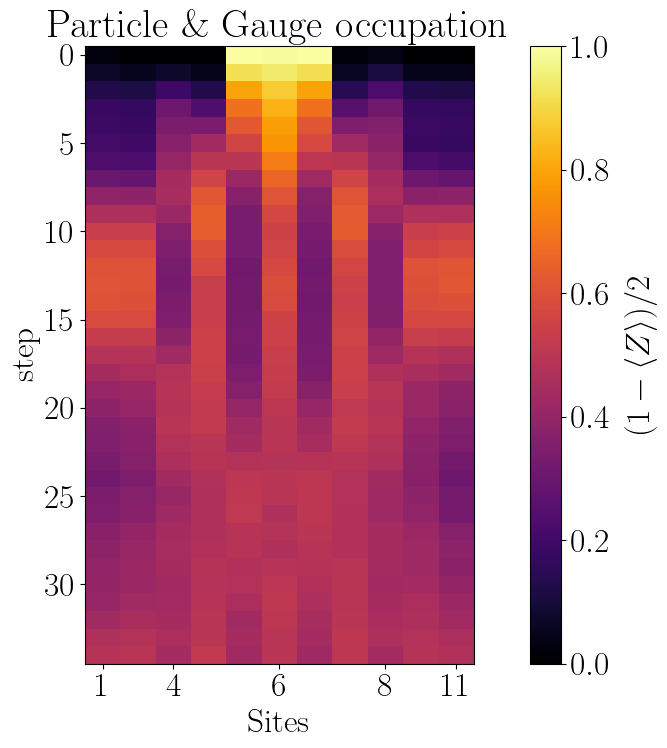

In [5]:
from utils.postselection import simulate_postselected_operators
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    pauli_expectations, samples_dicts, postselected_samples_dicts = simulate_postselected_operators(fake_backend, sampler_options, circuits[i], postselection_operators_funcs[i], observable_generating_funcs[i], return_samples_dicts=True, return_postselected_samples_dicts=True)
    pauli_expectations = (1-pauli_expectations)/2
    x_t_plot(pauli_expectations)

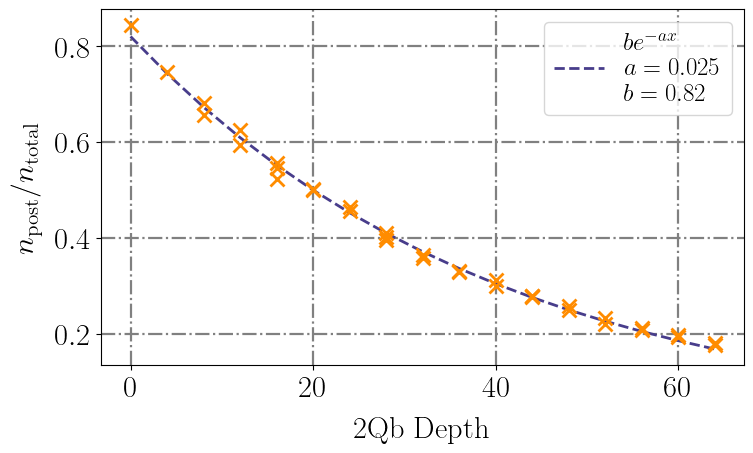

In [5]:
from z2chain.plotting import plot_n_discarded_samples
from utils.circs import depth2qb

plot_n_discarded_samples(samples_dicts, postselected_samples_dicts, x_arr=np.array([depth2qb(circ) for circ in circuits[-1]]), xlabel="2Qb Depth", regression=True, filepath="postselected_samples.pdf")

In [3]:
layout

[19, 18, 14, 0, 1, 2, 3, 4, 5, 6, 7]